## Counting Cases

In [ ]:
# Success/Failure 세기
from pathlib import Path
import pandas as pd
import os

# Simulate reading multiple files by reusing the same file for demonstration
folder_path = Path('./DS_experiment_data/ALL_beta')
csv_files = folder_path.glob('*.csv')

# Initialize counters
success_count = 0
failure_count = 0
distance_v_diff_count = [[0,0,0] for _ in range(3)]
MV_speed_count = [0,0,0]

# Process each CSV file
for file_path in csv_files:
    # Read the last row of the current CSV file
    
    
    file_name = os.path.basename(file_path)
    file_name = file_name.replace('.csv','')
    parts = file_name.split('_')
    data = pd.read_csv(file_path)
    # display(data.head())
    distance_v_diff_count[int(parts[1])//10-1][int(parts[2])//10-1]+=1
    # Extract MV and FV y-coordinates from the last row
    y_mv = data['y_MV'].iloc[-1]
    y_fv = data['y_FV'].iloc[-1]
    MV_speed_count[int(parts[3])//10-4]+=1
    # Determine success or failure
    if y_mv < y_fv:
        success_count += 1
    else:
        failure_count += 1
print('Vdiff: 10, 20, 30')
for i, col in enumerate(distance_v_diff_count):
    print((i+1)*10,'m',col)
print(MV_speed_count)
# Display the counts
(success_count, failure_count)



In [ ]:
display(data)

## Logistic Regression learning

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import math
import os
import seaborn as sns

vehicle_length = 4.18  # meters
vehicle_width = 1.99  # meters

def process_file(file_path):
    lane_x_ref = 13.0
    centerline_ref = 14.75
    y_ref = -169
    # 파일에서 데이터를 읽어옵니다.
    data = pd.read_csv(file_path)

    # 첫 행의 Time 값을 기준으로 설정
    start_time = data.iloc[0]['Time']

    data = data[data['y_MV'] > -180]

    # 마지막 행의 y_MV가 y_FV보다 작으면 success, 크면 failure
    success = data.iloc[-1]['y_MV'] < data.iloc[-1]['y_FV']
    success = 1 if success else 0  # 성공은 1, 실패는 0으로 표현
    data['gap_btw_LV_MV'] = data['gap_btw_LV']-data['gap_btw_MV']-vehicle_length
    data['Yaw_MV'] = -(data['Yaw_MV']+90.25)
    data['lateral_speed_MV']=np.sin(data['Yaw_MV']*np.pi/180)*data['speed_MV']
    data['remained_distance'] = data['y_MV'] - y_ref - vehicle_length/2
    data['lateral_offset_MV'] = (data['remained_distance'] + vehicle_length/2)*np.sin(0.25*np.pi/180) + centerline_ref - data['x_MV'] # 

    data = data[data['lateral_offset_MV'] < 1.75]
    
    if success == 1:
        data = data[data['lateral_offset_MV'] < 1.75]
    else:
        data = data[data['y_MV'] < data['y_FV']]
    
    if (data['remained_distance'] < 0).any():
        print('Value incorrect :', file_path, success)
    
    # 나머지 변수 준비
    res=[]
    i = 0
    # gap 기준 : FV
    while i < len(data):
        res.append([
            data.iloc[i]['Time'],
            data.iloc[i]['speed_MV'],
            data.iloc[i]['speed_FV'],
            data.iloc[i]['speed_FV'] - data.iloc[0]['speed_MV'],
            data.iloc[i]['gap_btw_MV'],
            data.iloc[i]['gap_btw_LV'],
            data.iloc[i]['gap_btw_LV_MV'],
            data.iloc[i]['Yaw_MV'],
            data.iloc[i]['lateral_speed_MV'],
            data.iloc[i]['lateral_offset_MV'],
            data.iloc[i]['remained_distance'],
            1 if data.iloc[i]['LeftBlinker_MV'] else 0,
            success
        ])
        i+=10

    return res


In [15]:
folder_path = Path('./DS_experiment_data/ALL_beta/')  # 폴더 경로 지정
files = folder_path.glob('*.csv')

# 모든 파일을 처리하고 결과를 리스트에 저장
data_list=[]
isFirst = True
for file in files:
    data_list.extend(process_file(file))
    



# 리스트를 DataFrame으로 변환

df = pd.DataFrame(data_list, columns=['Time','speed_MV', 'speed_FV', 'speed_diff', 'gap_btw_MV', 'gap_btw_LV','gap_btw_LV_MV','Yaw_MV','lateral_speed_MV','lateral_offset_MV','remained_distance', 'LeftBlinker_MV', 'success'])

# NaN 값 처리 (여기서는 단순히 0으로 채움)
df.fillna(0, inplace=True)


In [27]:
# 특성과 타깃 분리
y = df['success']
X = df[['gap_btw_MV','speed_diff','lateral_offset_MV','remained_distance','LeftBlinker_MV']] #'gap_btw_LV'
# X = df[[ 'gap_btw_MV','speed_diff']]

In [28]:
X[800:860]

,gap_btw_MV,speed_diff,lateral_offset_MV,remained_distance,LeftBlinker_MV
800,28.015651,2.940,1.428736,88.609989,1
801,32.699111,9.938,0.101983,123.108185,0
802,31.355566,6.687,0.066990,115.030129,0
803,30.075353,3.786,-0.066890,107.306534,1
804,28.853412,1.023,-0.296404,99.917797,1
805,27.733196,-1.609,-0.546408,92.802006,1
806,27.178092,-4.117,-0.499117,85.478253,1
807,27.409179,-6.443,-0.075215,77.707447,1
808,28.389865,-8.116,0.538740,69.465313,1
809,30.021526,-9.034,1.352385,60.765431,1


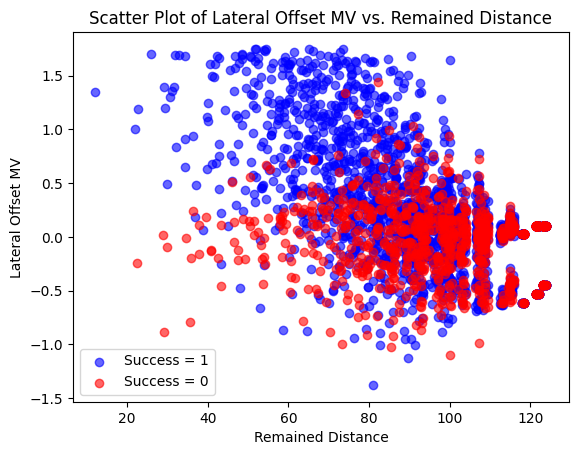

In [29]:
# Plotting
fig, ax = plt.subplots()

# Plot for success = 1
success_1 = df[df['success'] == 1]
ax.scatter(success_1['remained_distance'], success_1['lateral_offset_MV'], color='blue', label='Success = 1', alpha=0.6)

# Plot for success = 0
success_0 = df[df['success'] == 0]
ax.scatter(success_0['remained_distance'], success_0['lateral_offset_MV'], color='red', label='Success = 0', alpha=0.6)

# Labels and legend
ax.set_xlabel('Remained Distance')
ax.set_ylabel('Lateral Offset MV')
ax.set_title('Scatter Plot of Lateral Offset MV vs. Remained Distance')
ax.legend()

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


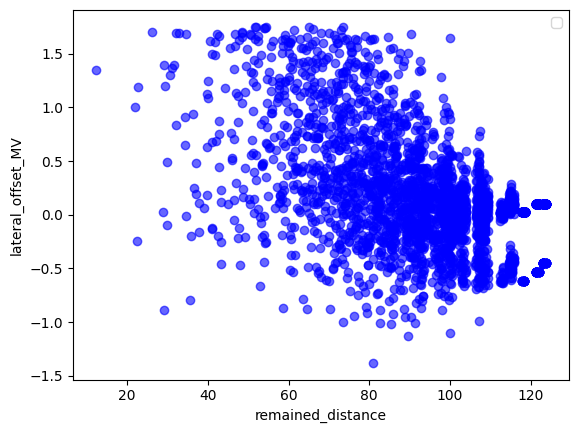

In [34]:
# Plotting
fig, ax = plt.subplots()

# Plot for success = 1
x_item = 'remained_distance'
y_item = 'lateral_offset_MV'

ax.scatter(df[x_item], df[y_item], color='blue', alpha=0.6)

# Labels and legend
ax.set_xlabel(x_item)
ax.set_ylabel(y_item)
ax.legend()

plt.show()

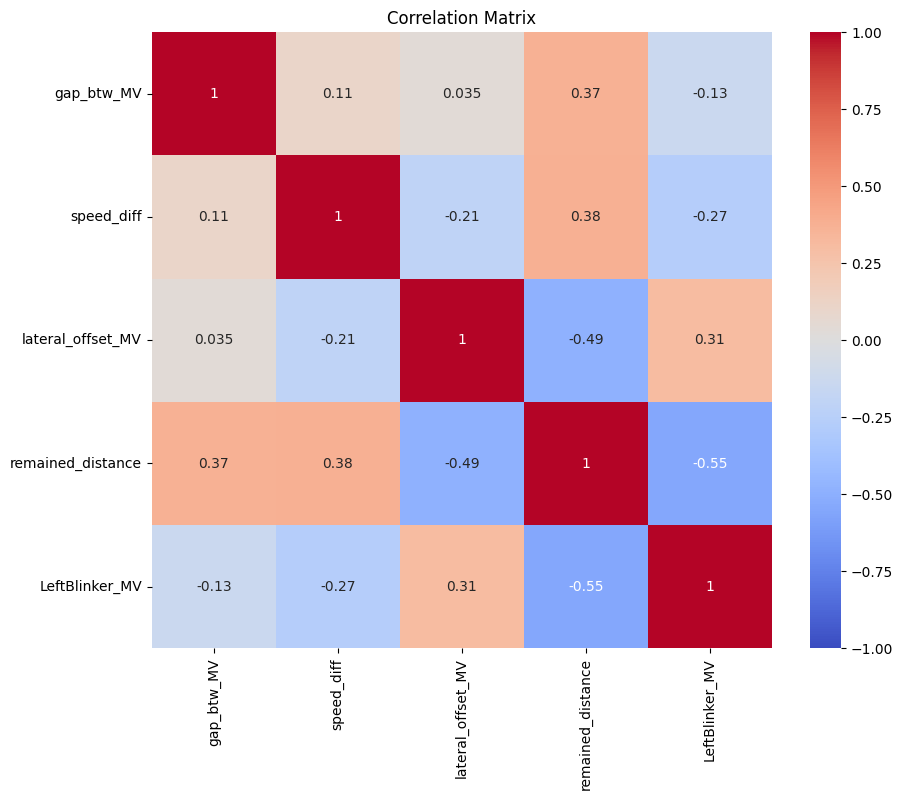

,VIF Factor,features
0,4.781634,gap_btw_MV
1,2.926261,speed_diff
2,1.299050,lateral_offset_MV
3,7.729825,remained_distance
4,2.061105,LeftBlinker_MV


In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 상관관계 매트릭스 계산
correlation_matrix = X.corr()


# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


## VIF describe
vif = pd.DataFrame()


vif["VIF Factor"]= [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif["features"]=X.columns
vif

In [32]:
selections = [['gap_btw_MV', 'speed_diff' ,'lateral_offset_MV','remained_distance','LeftBlinker_MV'],
              ['gap_btw_MV', 'speed_diff', 'lateral_offset_MV','LeftBlinker_MV'],
              ['gap_btw_MV', 'speed_diff', 'lateral_offset_MV','remained_distance'],
              ['gap_btw_MV', 'speed_diff','LeftBlinker_MV'], 
              ['gap_btw_MV', 'speed_diff']]
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40)
# test = 0.1, random_state = 40

# Calculate the log-likelihood
for select in selections:
    X = df[select]
    model = sm.Logit(y, sm.add_constant(X))
    log_reg_sm = model.fit()
    print(f"C-index (ROC AUC score): {roc_auc_score(y,log_reg_sm.predict(sm.add_constant(X)))}")
    print('AIC:', log_reg_sm.aic)
    print('BIC:', log_reg_sm.bic)
    display(log_reg_sm.summary())
X = df[selections[0]]
model = sm.Logit(y, sm.add_constant(X))
log_reg_sm = model.fit()
print(f"C-index (ROC AUC score): {roc_auc_score(y,log_reg_sm.predict(sm.add_constant(X)))}")

Optimization terminated successfully.
         Current function value: 0.297803
         Iterations 8
C-index (ROC AUC score): 0.9363108290184661
AIC: 1721.3916102220217
BIC: 1757.1640140745437


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                success   No. Observations:                 2870
Model:                          Logit   Df Residuals:                     2864
Method:                           MLE   Df Model:                            5
Date:                Thu, 08 Aug 2024   Pseudo R-squ.:                  0.5247
Time:                        21:10:19   Log-Likelihood:                -854.70
converged:                       True   LL-Null:                       -1798.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.7383      0.442      3.930      0.000       0.871       2.605
gap_btw_MV            0.2681      0.011     24.682      0.000       0.247       0.289
speed_diff           -0.1355      0.008    -16.846      0.000      -0.151      -0.120
lateral_offset_MV     1.1224      0.164      6.832      0.000       0.800       1.444
remained_distance    -0.0356      0.005     -7.825      0.000      -0.045      -0.027
LeftBlinker_MV        0.8508      0.144      5.913      0.000       0.569       1.133
=====================================================================================
"""

Optimization terminated successfully.
         Current function value: 0.308739
         Iterations 8
C-index (ROC AUC score): 0.9315361373967629
AIC: 1782.159123089335
BIC: 1811.9694596331033


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                success   No. Observations:                 2870
Model:                          Logit   Df Residuals:                     2865
Method:                           MLE   Df Model:                            4
Date:                Thu, 08 Aug 2024   Pseudo R-squ.:                  0.5072
Time:                        21:10:19   Log-Likelihood:                -886.08
converged:                       True   LL-Null:                       -1798.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.5688      0.157     -9.969      0.000      -1.877      -1.260
gap_btw_MV            0.2386      0.010     24.830      0.000       0.220       0.257
speed_diff           -0.1366      0.008    -17.653      0.000      -0.152      -0.121
lateral_offset_MV     1.4697      0.153      9.604      0.000       1.170       1.770
LeftBlinker_MV        1.3550      0.131     10.352      0.000       1.098       1.612
=====================================================================================
"""

Optimization terminated successfully.
         Current function value: 0.304100
         Iterations 8
C-index (ROC AUC score): 0.9326464723622355
AIC: 1755.536275198343
BIC: 1785.3466117421112


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                success   No. Observations:                 2870
Model:                          Logit   Df Residuals:                     2865
Method:                           MLE   Df Model:                            4
Date:                Thu, 08 Aug 2024   Pseudo R-squ.:                  0.5146
Time:                        21:10:19   Log-Likelihood:                -872.77
converged:                       True   LL-Null:                       -1798.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.1995      0.361      8.872      0.000       2.493       3.906
gap_btw_MV            0.2673      0.011     24.904      0.000       0.246       0.288
speed_diff           -0.1338      0.008    -16.942      0.000      -0.149      -0.118
lateral_offset_MV     1.1326      0.160      7.070      0.000       0.819       1.447
remained_distance    -0.0467      0.004    -11.444      0.000      -0.055      -0.039
=====================================================================================
"""

Optimization terminated successfully.
         Current function value: 0.327219
         Iterations 8
C-index (ROC AUC score): 0.9219599520018137
AIC: 1886.2395422623874
BIC: 1910.087811497402


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                success   No. Observations:                 2870
Model:                          Logit   Df Residuals:                     2866
Method:                           MLE   Df Model:                            3
Date:                Thu, 08 Aug 2024   Pseudo R-squ.:                  0.4777
Time:                        21:10:19   Log-Likelihood:                -939.12
converged:                       True   LL-Null:                       -1798.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.5352      0.154     -9.983      0.000      -1.837      -1.234
gap_btw_MV         0.2334      0.009     25.284      0.000       0.215       0.252
speed_diff        -0.1353      0.007    -18.047      0.000      -0.150      -0.121
LeftBlinker_MV     1.6125      0.127     12.678      0.000       1.363       1.862
==================================================================================
"""

Optimization terminated successfully.
         Current function value: 0.358964
         Iterations 7
C-index (ROC AUC score): 0.9032350196912058
AIC: 2066.45349523573
BIC: 2084.339697161991


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                success   No. Observations:                 2870
Model:                          Logit   Df Residuals:                     2867
Method:                           MLE   Df Model:                            2
Date:                Thu, 08 Aug 2024   Pseudo R-squ.:                  0.4270
Time:                        21:10:19   Log-Likelihood:                -1030.2
converged:                       True   LL-Null:                       -1798.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4124      0.121     -3.417      0.001      -0.649      -0.176
gap_btw_MV     0.2053      0.008     25.341      0.000       0.189       0.221
speed_diff    -0.1308      0.007    -19.110      0.000      -0.144      -0.117
==============================================================================
"""

Optimization terminated successfully.
         Current function value: 0.297803
         Iterations 8
C-index (ROC AUC score): 0.9363108290184661


In [33]:
display(log_reg_sm.summary())
print(np.exp(log_reg_sm.params))
# print(np.exp(log_reg_sm.params))
# params = log_reg_sm.params
# conf = log_reg_sm.conf_int()
# conf['Odds Ratio'] = params
# print(conf.columns)
# conf.columns = ['5%', '95%', 'Odds Ratio']
# print(np.exp(conf))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                success   No. Observations:                 2870
Model:                          Logit   Df Residuals:                     2864
Method:                           MLE   Df Model:                            5
Date:                Thu, 08 Aug 2024   Pseudo R-squ.:                  0.5247
Time:                        21:10:19   Log-Likelihood:                -854.70
converged:                       True   LL-Null:                       -1798.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.7383      0.442      3.930      0.000       0.871       2.605
gap_btw_MV            0.2681      0.011     24.682      0.000       0.247       0.289
speed_diff           -0.1355      0.008    -16.846      0.000      -0.151      -0.120
lateral_offset_MV     1.1224      0.164      6.832      0.000       0.800       1.444
remained_distance    -0.0356      0.005     -7.825      0.000      -0.045      -0.027
LeftBlinker_MV        0.8508      0.144      5.913      0.000       0.569       1.133
=====================================================================================
"""

const                5.687626
gap_btw_MV           1.307422
speed_diff           0.873269
lateral_offset_MV    3.072313
remained_distance    0.965018
LeftBlinker_MV       2.341435
dtype: float64


## PLOT probability

C:\Users\User\AppData\Local\Temp\ipykernel_40140\3415042621.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(16,4))


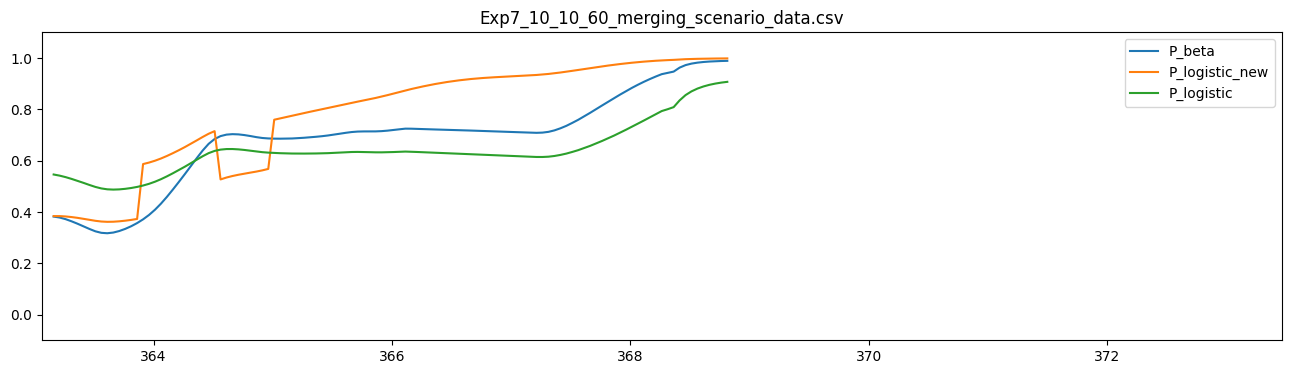

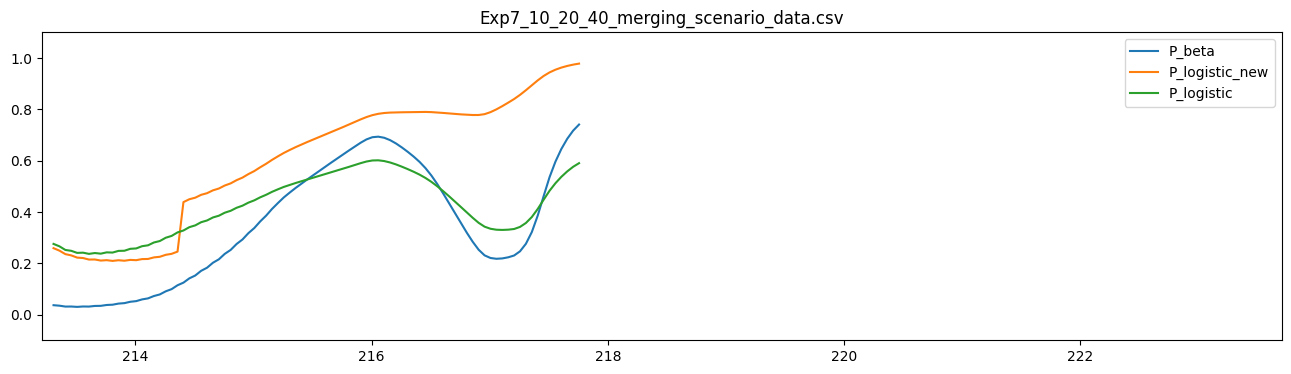

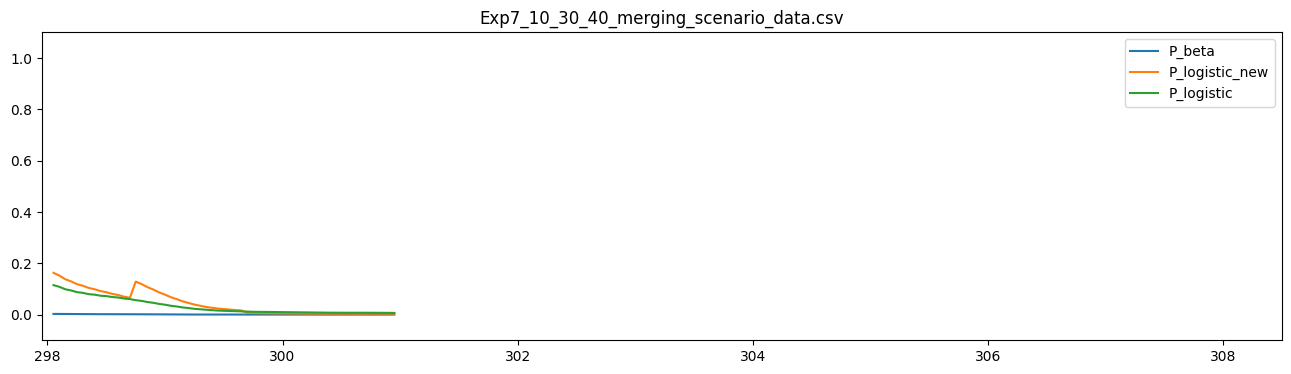

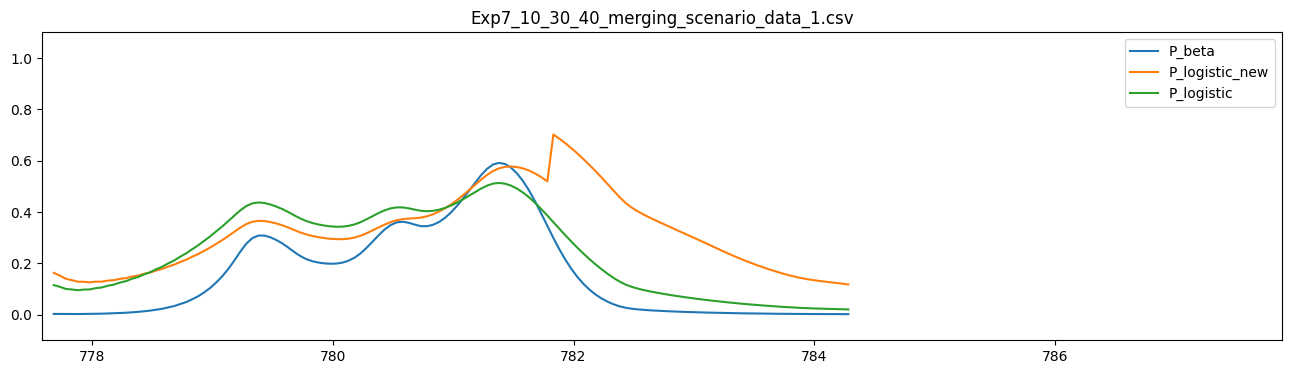

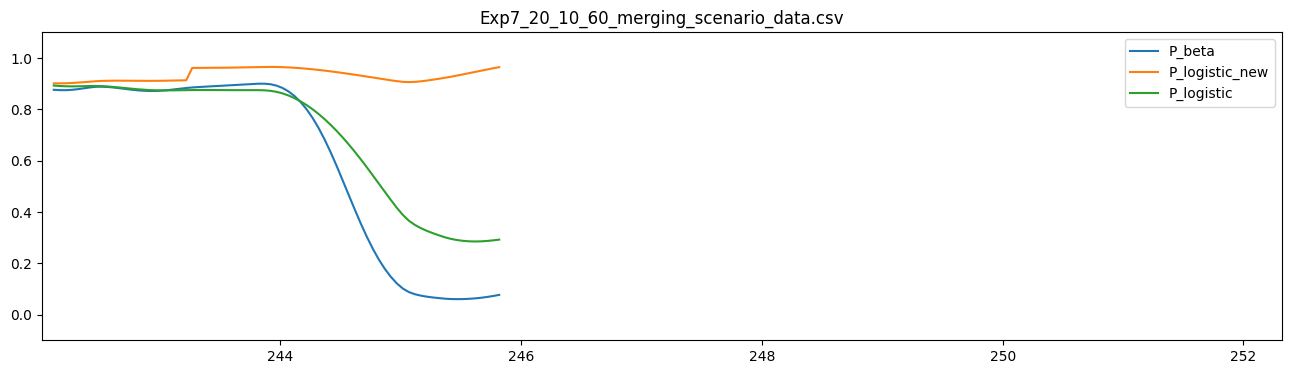

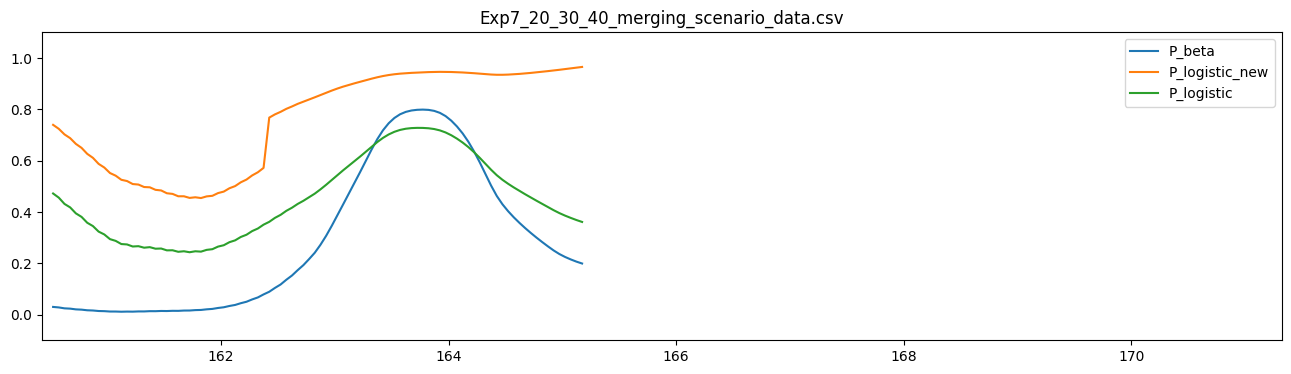

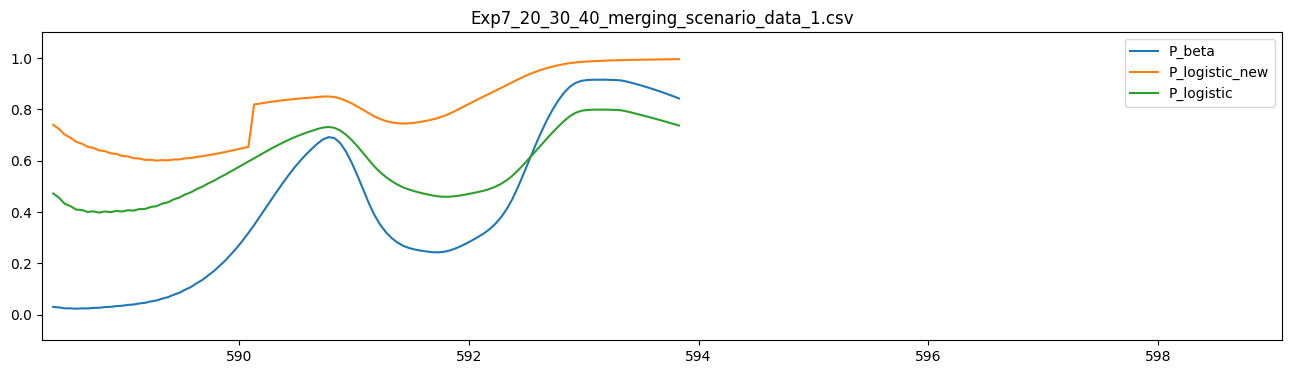

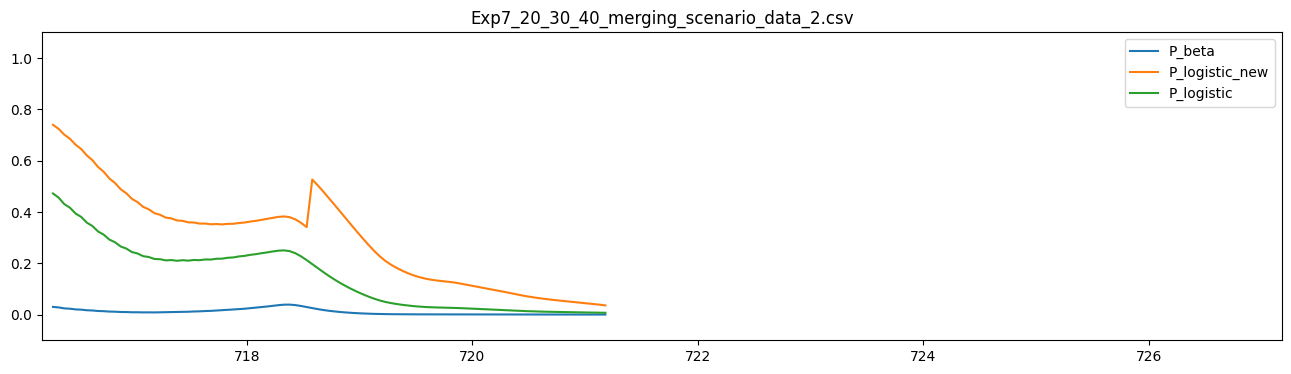

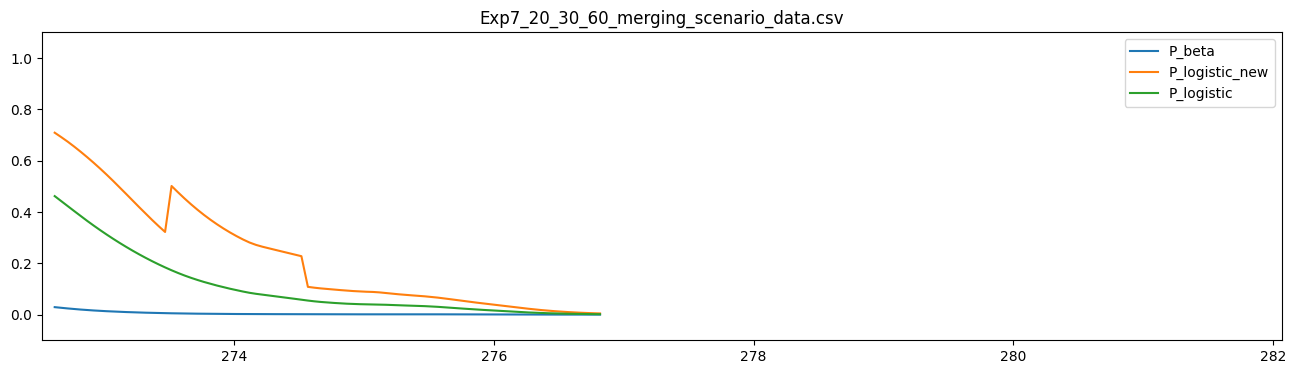

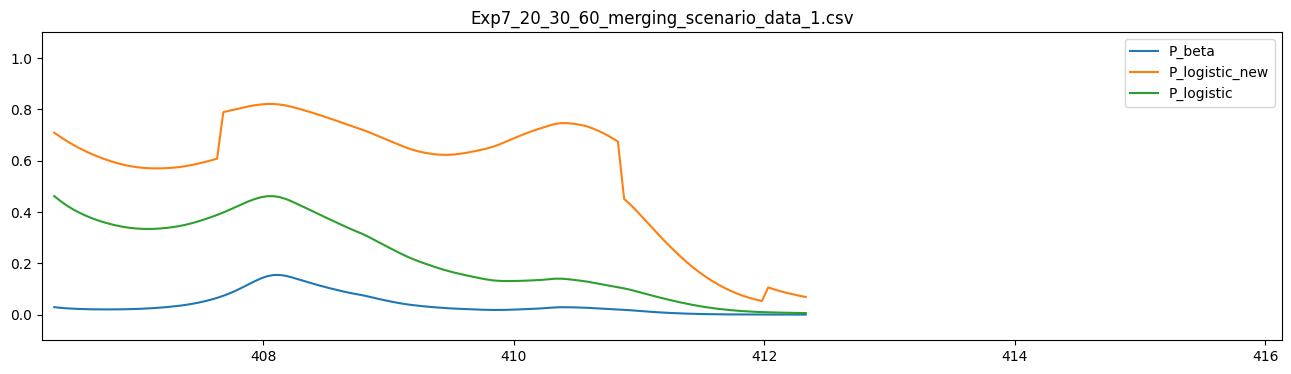

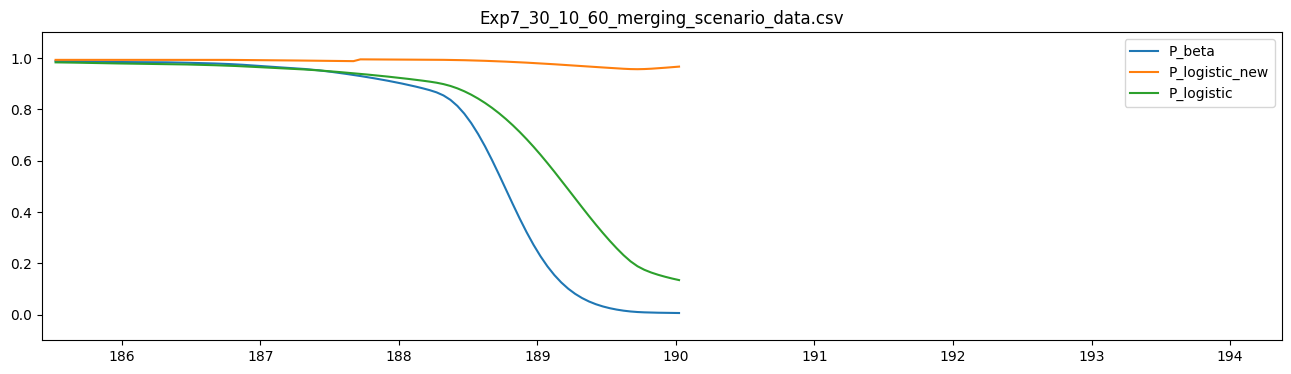

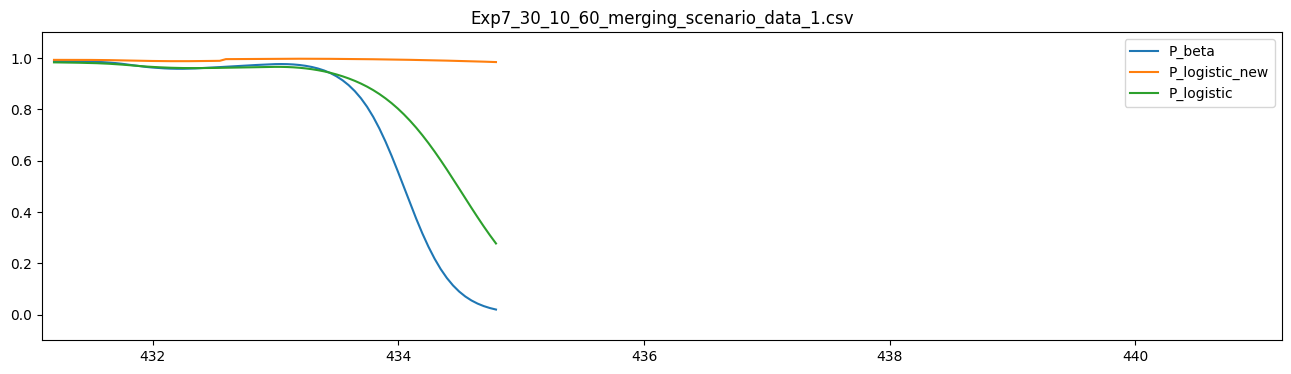

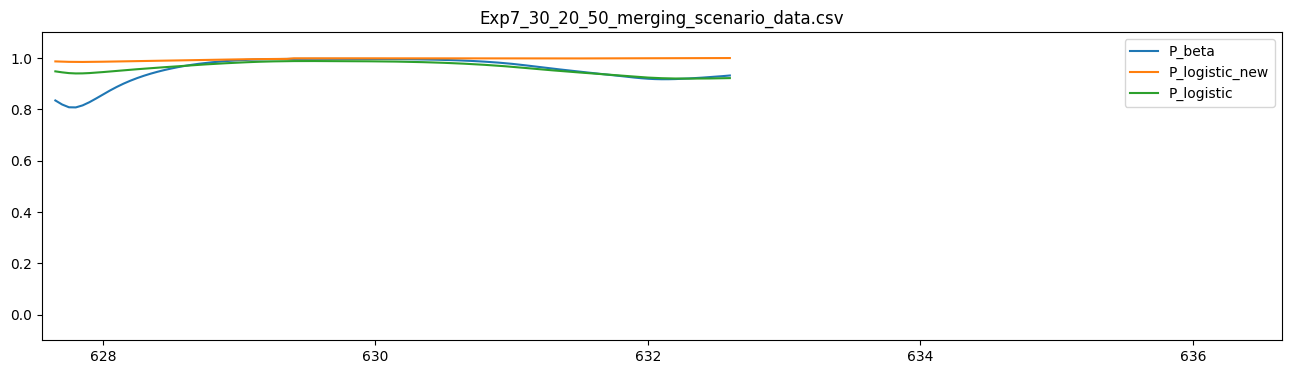

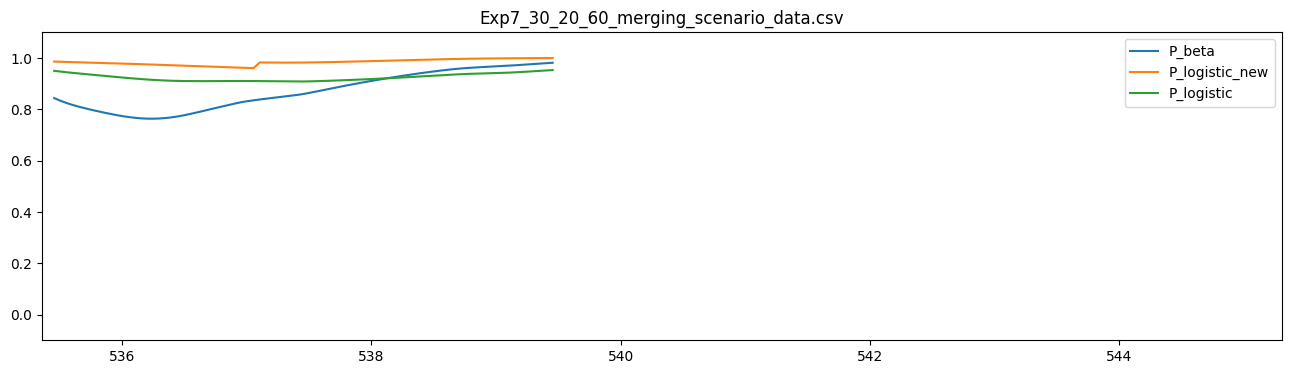

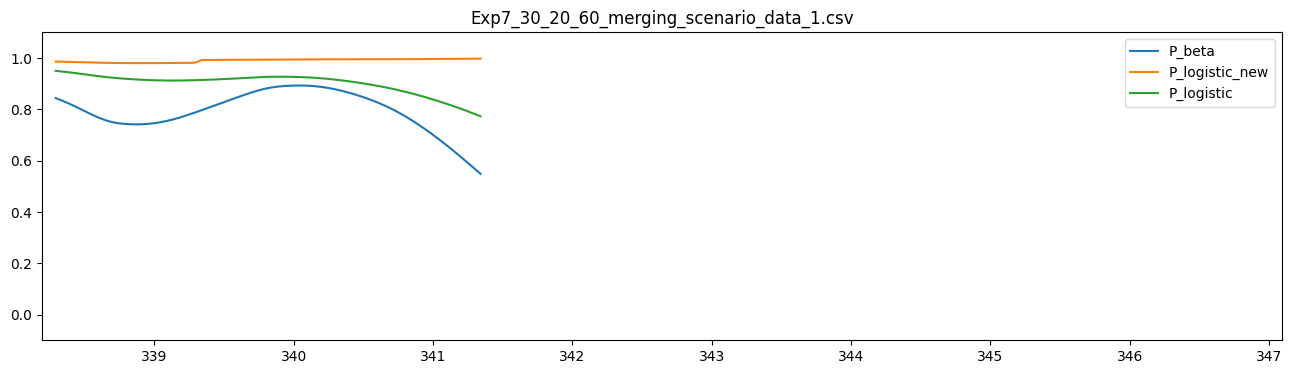

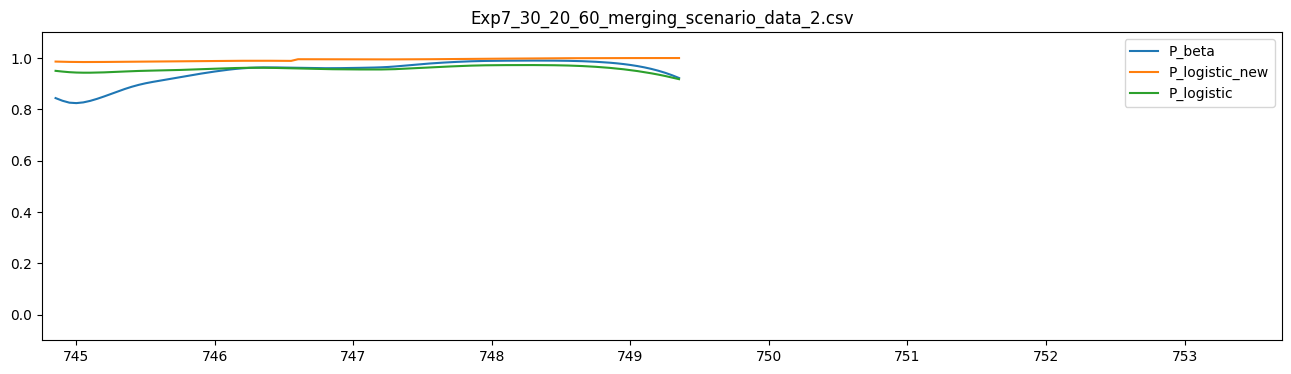

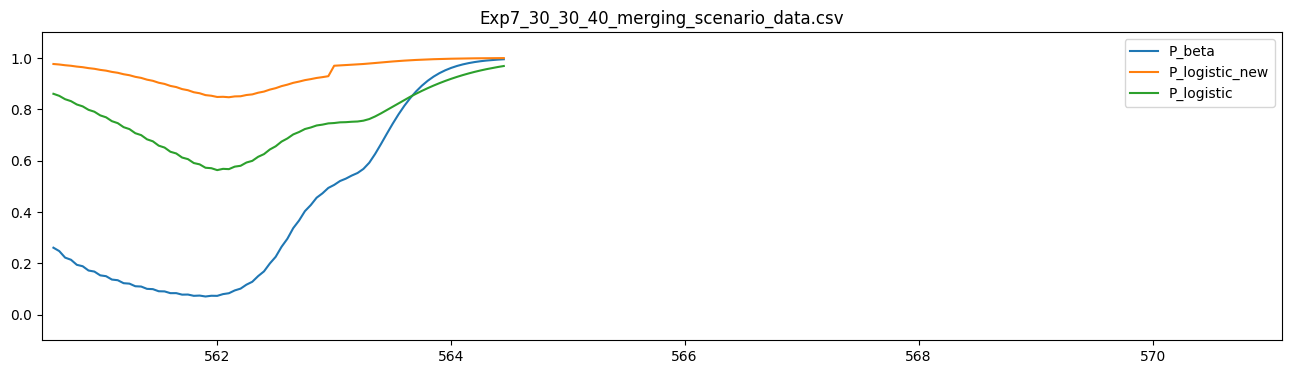

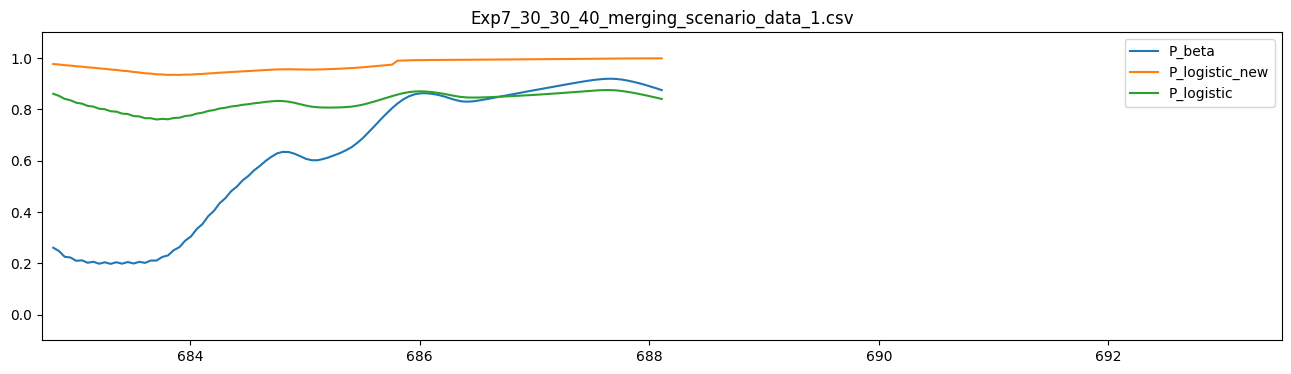

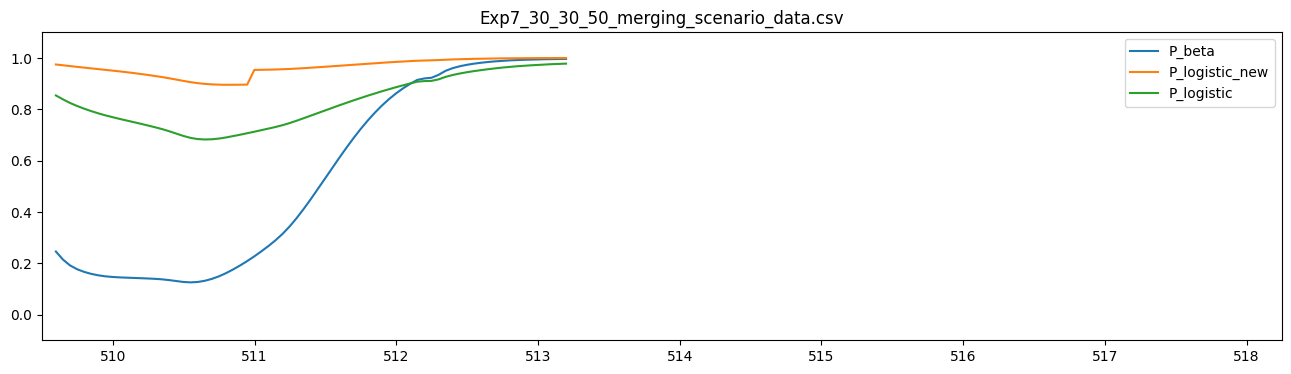

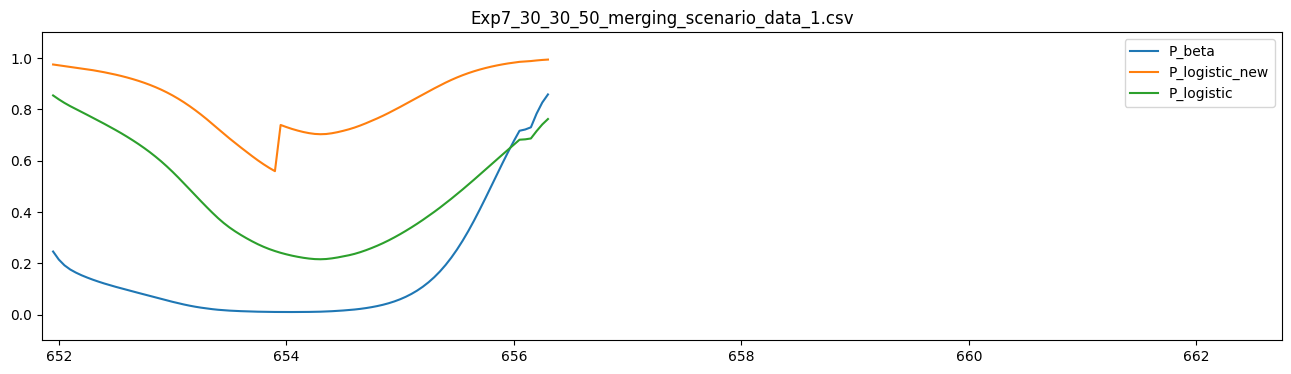

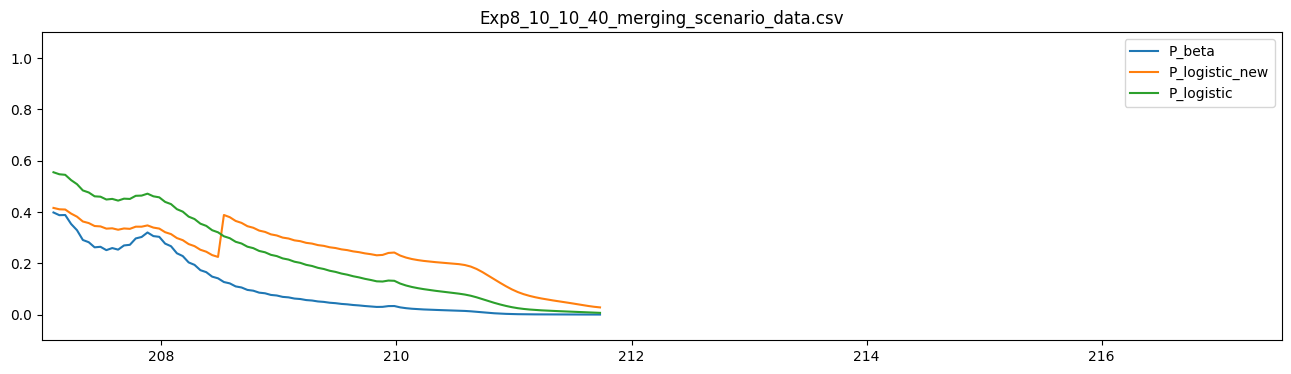

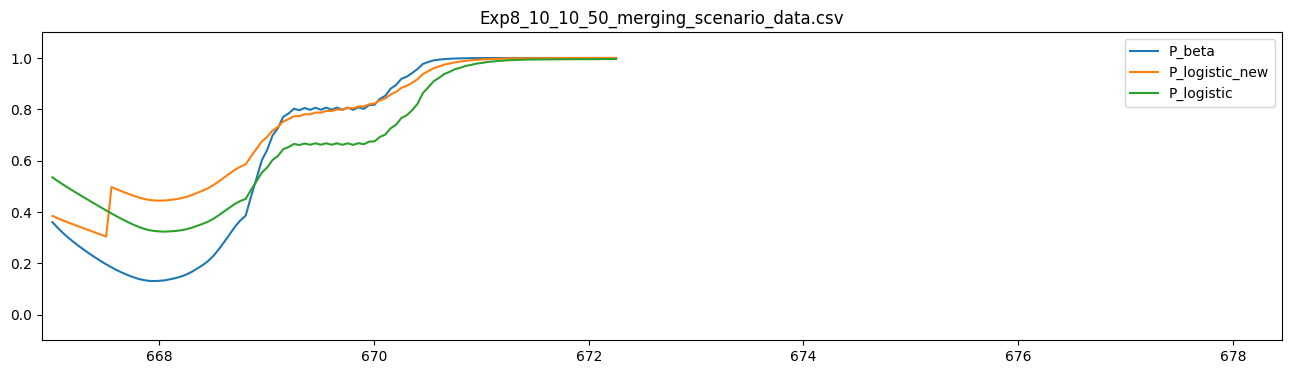

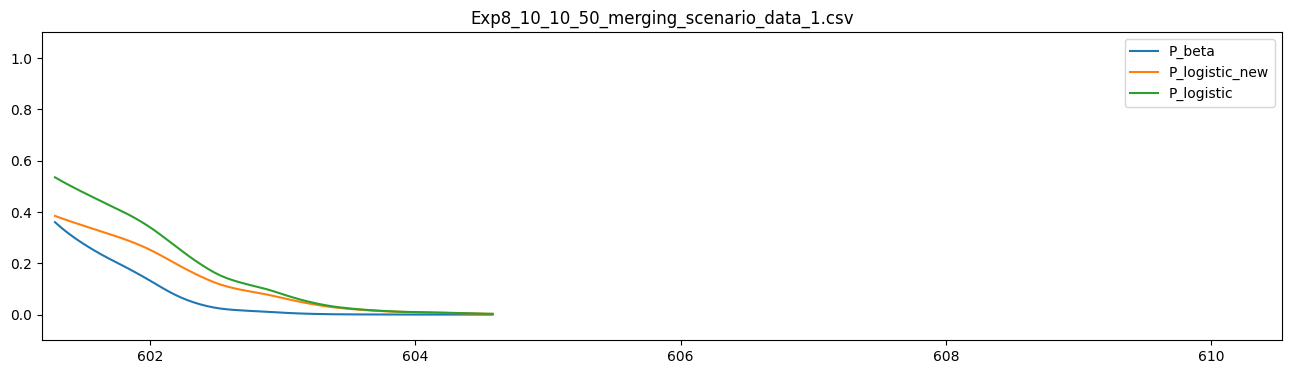

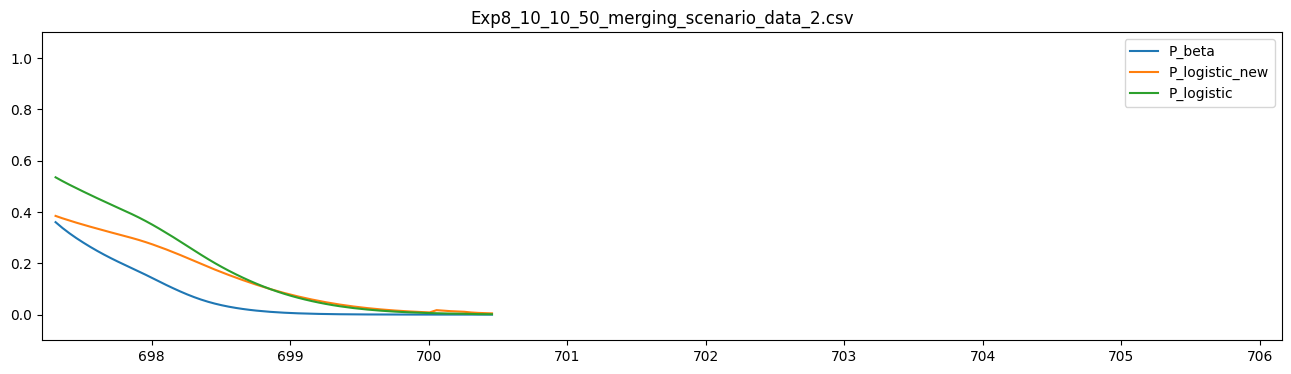

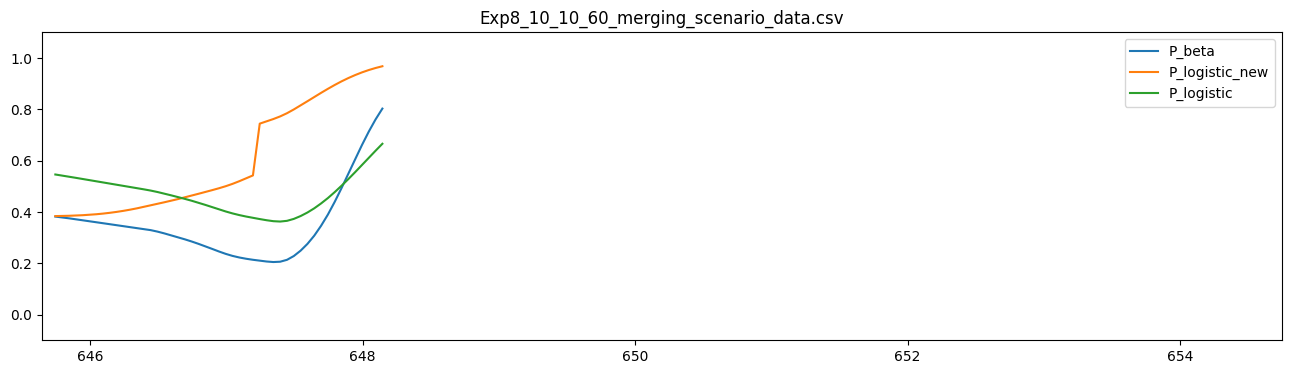

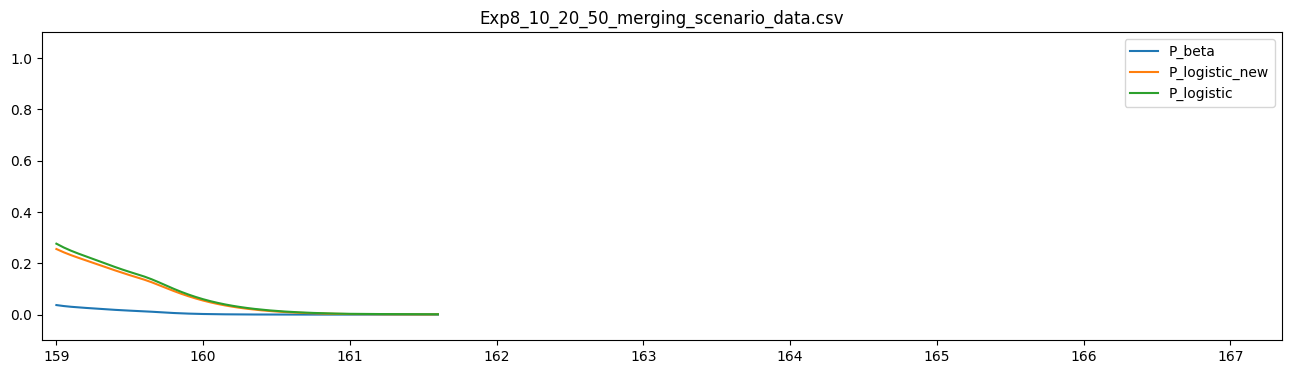

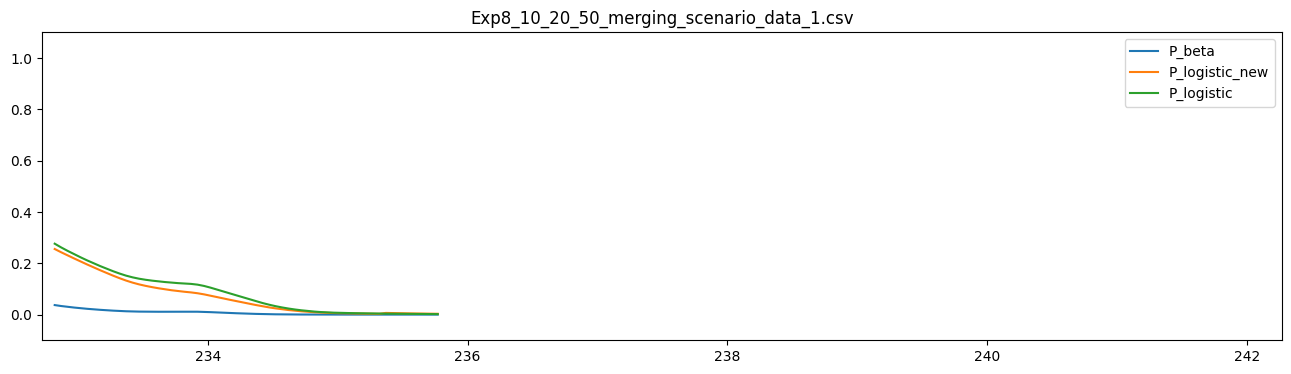

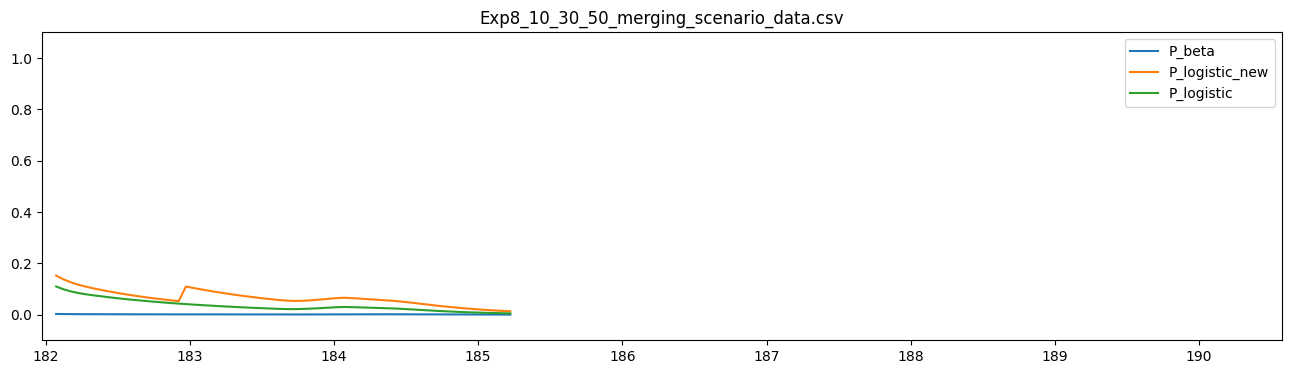

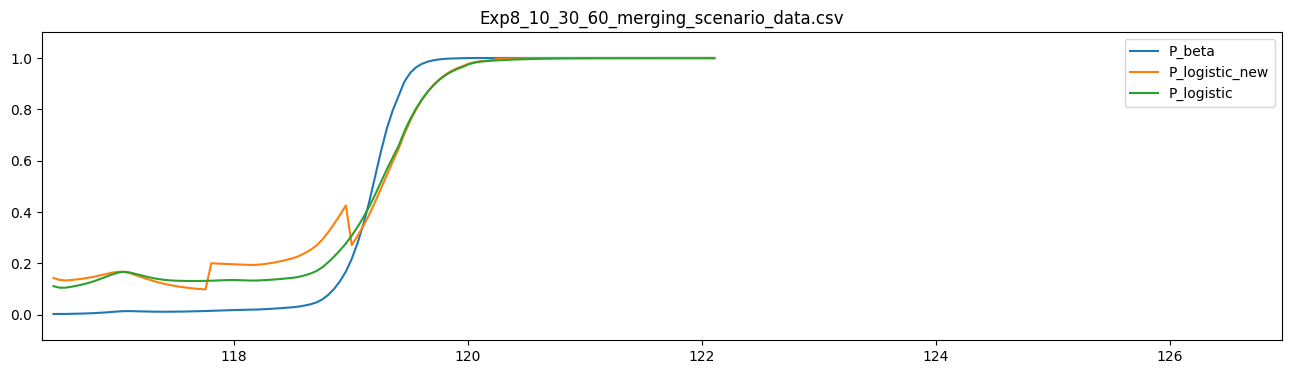

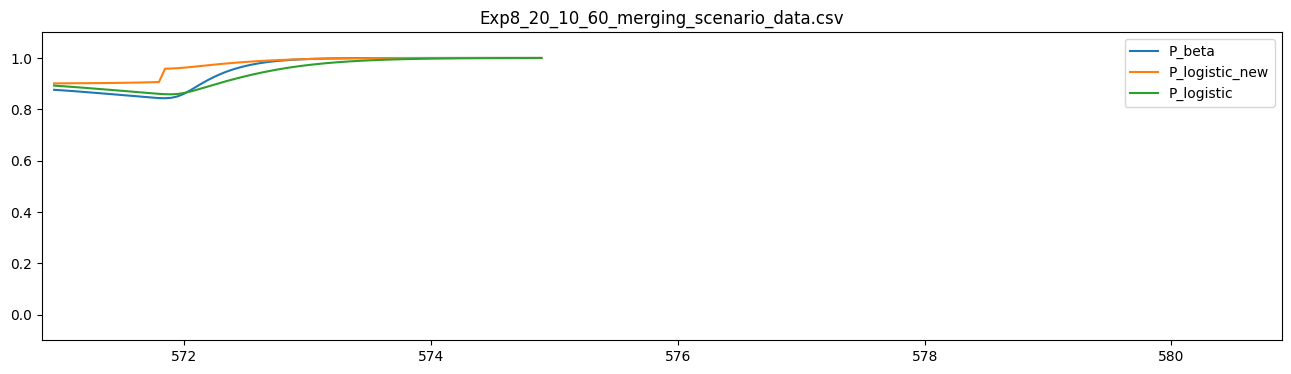

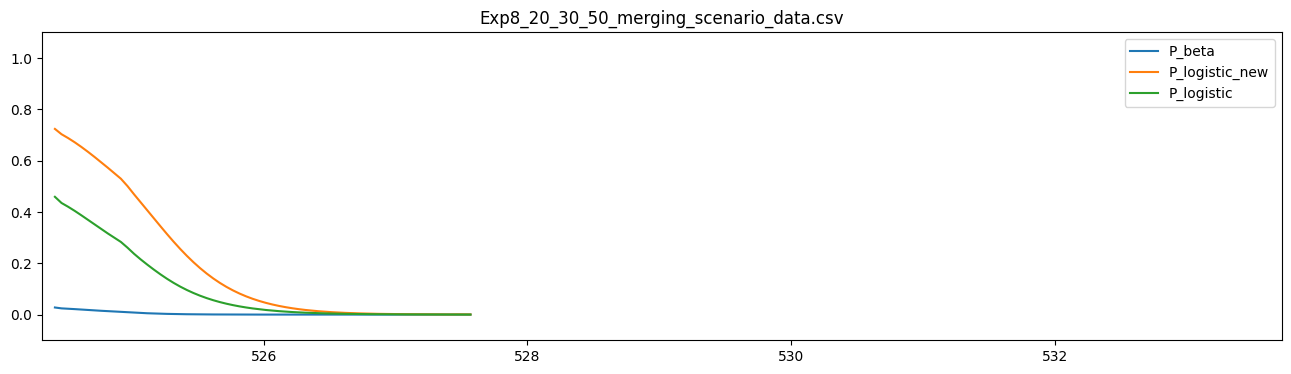

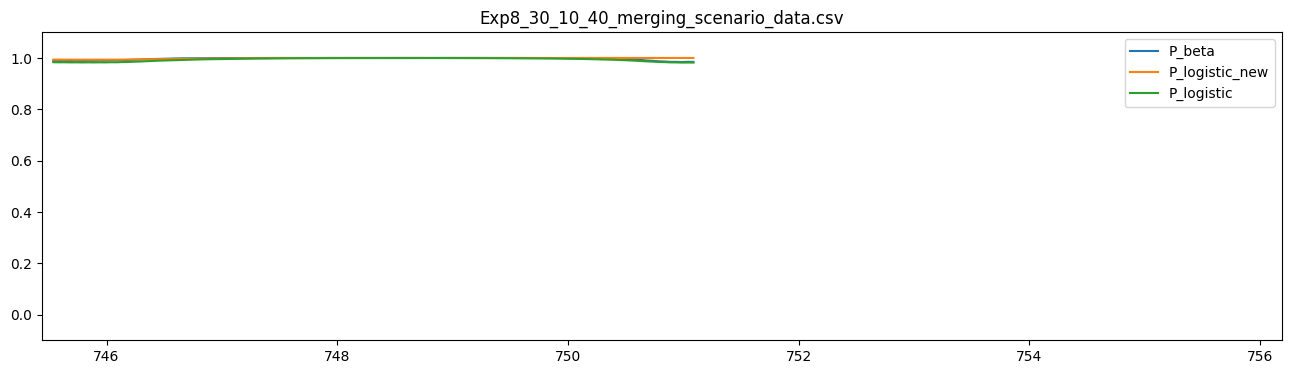

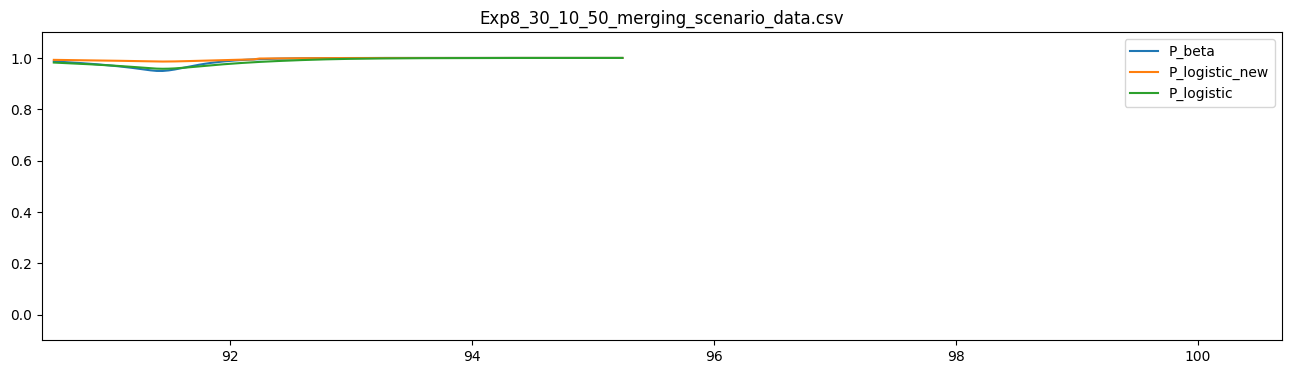

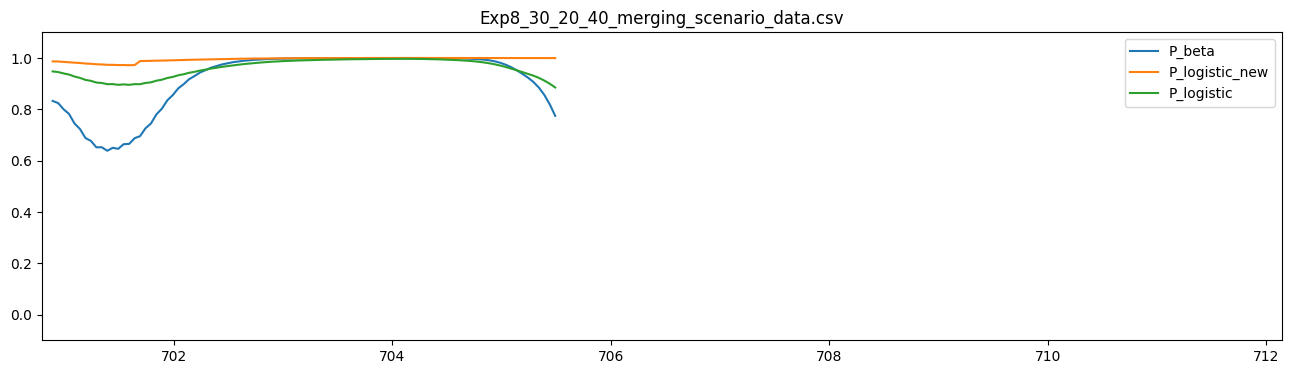

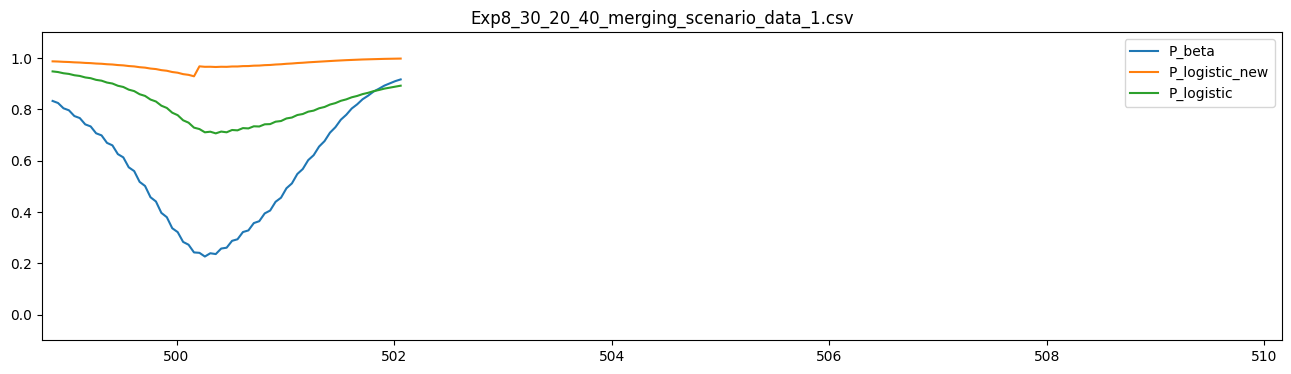

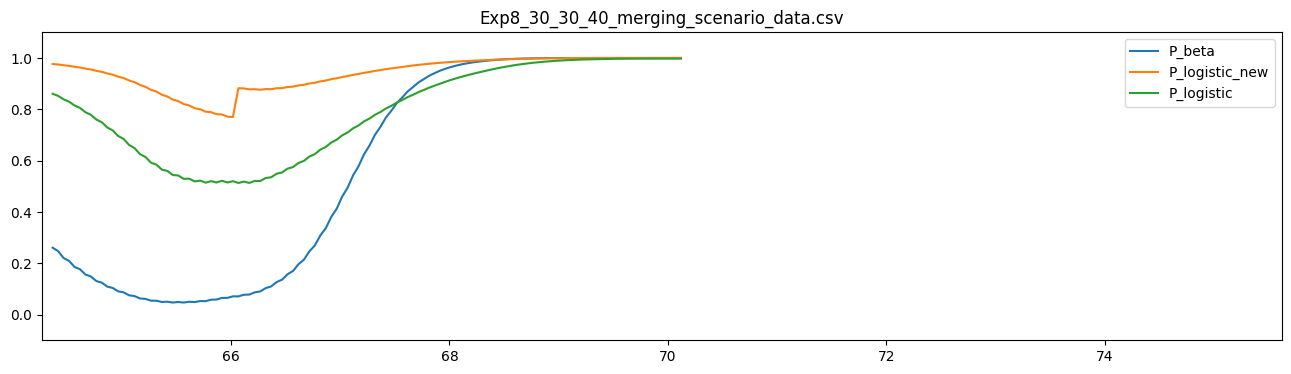

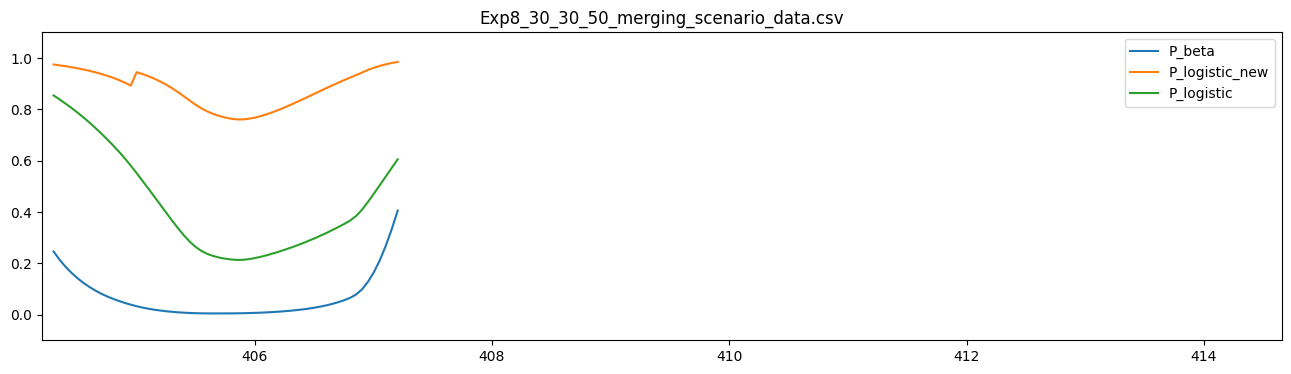

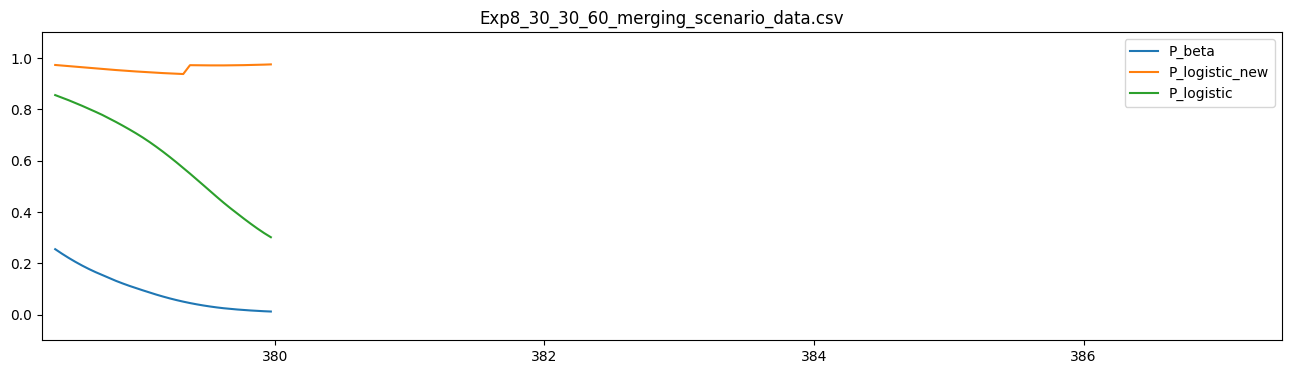

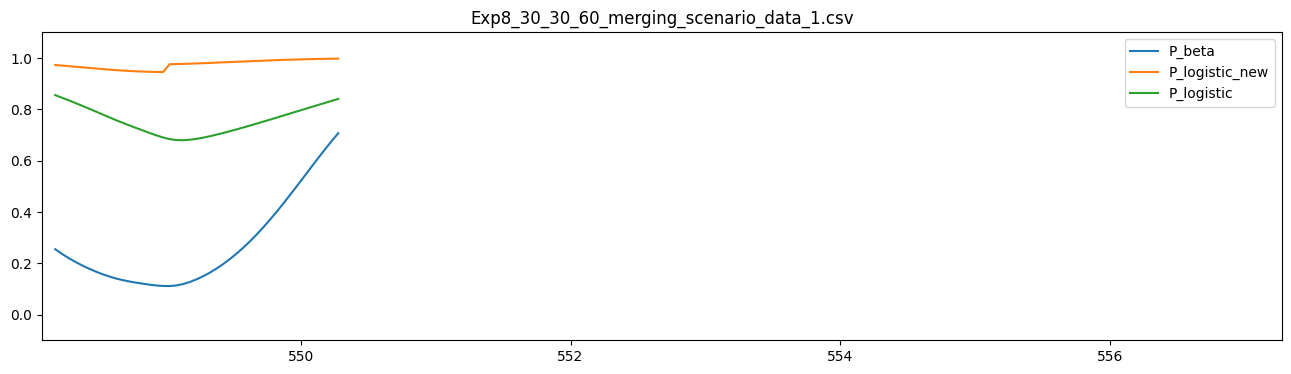

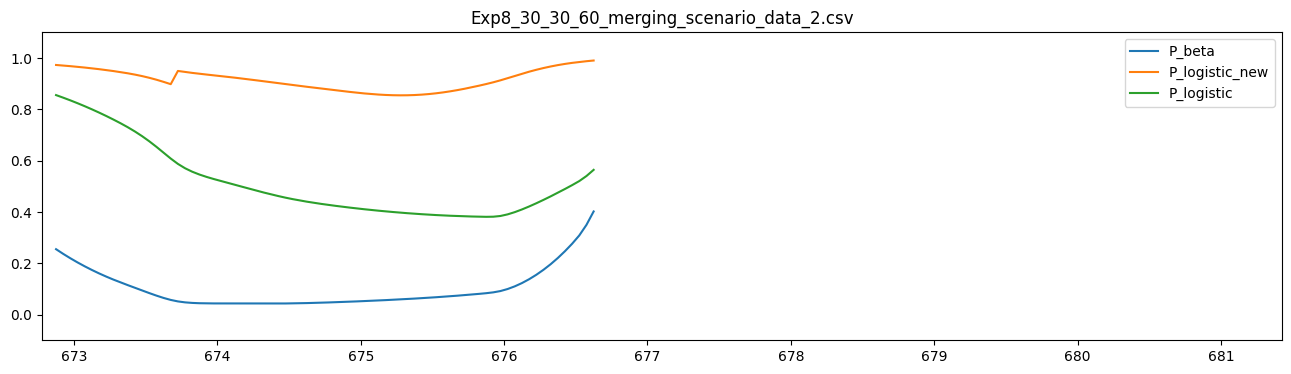

In [36]:
lane_x_ref = 13.0
centerline_ref = 14.75
y_ref = -169
vehicle_length = 4.18  # meters
vehicle_width = 1.99  # meters

for i in range(7, 9):

    folder_path = Path('./DS_experiment_data/Exp'+str(i)+'/')
    csv_files = folder_path.glob('*.csv')

    for file_path in csv_files:
        ID = os.path.basename(file_path)
        # Initialize
        data = pd.DataFrame()

        data = pd.read_csv(file_path)
        data['gap_btw_LV_MV'] = data['gap_btw_LV']-data['gap_btw_MV']-vehicle_length
        data['lateral_speed_MV']=np.sin(data['Yaw_MV']*np.pi/180)*data['speed_MV']
        data['remained_distance'] = data['y_MV'] - y_ref - vehicle_length/2
        data['lateral_offset_MV'] = (data['remained_distance']+ vehicle_length/2)*np.sin(0.25*np.pi/180) + centerline_ref - data['x_MV']
        data['LeftBlinker_MV'] = data['LeftBlinker_MV'].astype(int)
        X = data[[ 'gap_btw_MV', 'speed_diff','lateral_offset_MV','remained_distance','LeftBlinker_MV']]
        
        data['P_logistic_new'] = log_reg_sm.predict(sm.add_constant(X))
        data.loc[~((data['x_MV'] > 13.3) & (data['gap_btw_MV'] > -vehicle_length)), ['P_beta', 'P_logistic', 'P_logistic_new']] = np.nan
        plt.figure(figsize=(16,4))
            
        plt.title(ID)
        plt.xlim([data['Time'].iloc[0]-0.1,data['Time'].iloc[-1]+0.1])
        plt.ylim([-0.1, 1.1])
        # plt.plot(data['Time'], data['P_normal_equation'], label='P_normal_equation')
        plt.plot(data['Time'], data['P_beta'], label='P_beta')
        plt.plot(data['Time'], data['P_logistic_new'], label='P_logistic_new')
        plt.plot(data['Time'], data['P_logistic'], label='P_logistic')
        plt.legend()


In [37]:
# 임계값 정의 (일반적으로 0.5를 사용함)
threshold = 0.5

# 테스트 데이터에 대한 확률 예측
predictions_proba = log_reg_sm.predict(sm.add_constant(X_test))

# 확률을 이진 예측값으로 변환
predictions = (predictions_proba >= threshold).astype(int)

# 평가 지표 출력
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))
cm = confusion_matrix(y_test, predictions)

              precision    recall  f1-score   support

           0       0.78      0.77      0.77        95
           1       0.89      0.89      0.89       192

    accuracy                           0.85       287
   macro avg       0.83      0.83      0.83       287
weighted avg       0.85      0.85      0.85       287

Accuracy: 0.8501742160278746


In [38]:
predictions_proba.values[0]

0.21469972670536927

In [39]:
# 계수(coefficient)와 절편(intercept) 얻기
# 결과 객체에서 계수를 가져옵니다.
coefficients = log_reg_sm.params

# 결과 객체에서 절편(상수항)을 가져옵니다.
intercept = log_reg_sm.params[0]  # 첫 번째 값이 상수항입니다.

# 결과 객체에서 나머지 계수들을 가져옵니다.
other_coeffs = log_reg_sm.params[1:]  # 상수항을 제외한 나머지 계수들입니다.


# 모델의 식을 보다 직관적으로 출력하기
equation = f"log(p / (1 - p)) = {intercept:.4f}"
for i, coef in enumerate(other_coeffs, start=1):
    equation += f" + {coef:.4f}*X{i}"
print("Model equation:", equation)
print(coefficients)


Model equation: log(p / (1 - p)) = 1.7383 + 0.2681*X1 + -0.1355*X2 + 1.1224*X3 + -0.0356*X4 + 0.8508*X5
const                1.738293
gap_btw_MV           0.268057
speed_diff          -0.135512
lateral_offset_MV    1.122431
remained_distance   -0.035609
LeftBlinker_MV       0.850764
dtype: float64


In [40]:
# 모델 저장
import pickle


# 모델을 파일로 저장
with open('logit_model_new.pkl', 'wb') as file:
    pickle.dump(log_reg_sm, file)

In [282]:
log_reg_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                success   No. Observations:                 2870
Model:                          Logit   Df Residuals:                     2863
Method:                           MLE   Df Model:                            6
Date:                Fri, 26 Jul 2024   Pseudo R-squ.:                  0.5379
Time:                        18:32:46   Log-Likelihood:                -830.89
converged:                       True   LL-Null:                       -1798.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.3653      0.459      2.972      0.003       0.465       2.266
gap_btw_MV            0.2611      0.011     23.868      0.000       0.240       0.283
speed_diff           -0.1391      0.008    -16.854      0.000      -0.155      -0.123
Yaw_MV                0.3230      0.049      6.560      0.000       0.226       0.419
lateral_offset_MV     0.6545      0.183      3.568      0.000       0.295       1.014
remained_distance    -0.0310      0.005     -6.524      0.000      -0.040      -0.022
LeftBlinker_MV        0.6914      0.148      4.684      0.000       0.402       0.981
=====================================================================================
"""

In [ ]:
## VIF describe
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[['gap_btw_MV','speed_diff', 'speed_MV','LeftBlinker_MV', 'gap_btw_LV']]
vif = pd.DataFrame()


vif["VIF Factor"]= [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif["features"]=X.columns
vif

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# 상관관계 매트릭스 계산
correlation_matrix = X.corr()

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
## VIF describe
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[['gap_btw_MV' ,'speed_diff', 'speed_MV' ,'LeftBlinker_MV']]
vif = pd.DataFrame()


vif["VIF Factor"]= [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif["features"]=X.columns
vif

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# 상관관계 매트릭스 계산
correlation_matrix = X.corr()

# 히트맵 그리기
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True,annot_kws={"size": 21},fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, xticklabels=False, yticklabels=False)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)  # 컬러 바 숫자 크기 설정
# plt.title('Correlation Matrix',)
plt.show()

In [ ]:
for i in range(7, 9):

    folder_path = Path('./DS_experiment_data/Exp'+str(i)+'/')
    csv_files = folder_path.glob('*.csv')

    for file_path in csv_files:
        ID = os.path.basename(file_path)
        # Initialize
        data = pd.DataFrame()

        data = pd.read_csv(file_path)
        data.loc[~((data['x_MV'] > 13.3) & (data['gap_btw_MV'] > -vehicle_length)), ['P_beta', 'P_logistic']] = np.nan
        
        plt.figure(figsize=((data['Time'][data['P_beta'].dropna().index[-1]]-data['Time'].loc[0])*2,4))
            
        plt.title(ID)
        # plt.xlim([data['Time'].iloc[0]-0.1,data['Time'].iloc[-1]+0.1])
        plt.ylim([-0.1, 1.1])
        plt.plot(data['Time'], data['P_beta'], label='P_beta')
        plt.plot(data['Time'], data['P_logistic'], label='P_logistic')
        plt.legend()

        # file_name = os.path.basename(file_path)
        # file_name = file_name.replace('.csv','')
        # print(file_name,'DONE')
    break

In [ ]:
for i in range(7, 9):

    folder_path = Path('./DS_experiment_data/Exp'+str(i)+'/')
    csv_files = folder_path.glob('*.csv')

    for file_path in csv_files:
        ID = os.path.basename(file_path)
        # Initialize
        data = pd.DataFrame()

        data = pd.read_csv(file_path)
        data.loc[~((data['x_MV'] > 13.3) & (data['gap_btw_MV'] > -vehicle_length)), ['P_normal_equation', 'P_beta', 'P_logistic']] = np.nan
        plt.figure(figsize=(16,4))
            
        plt.title(ID)
        plt.xlim([data['Time'].iloc[0]-0.1,data['Time'].iloc[-1]+0.1])
        plt.ylim([-0.1, 1.1])
        plt.plot(data['Time'], data['P_normal_equation'], label='P_normal_equation')
        plt.plot(data['Time'], data['P_beta'], label='P_beta')
        plt.plot(data['Time'], data['P_logistic'], label='P_logistic')
        plt.legend()

        # file_name = os.path.basename(file_path)
        # file_name = file_name.replace('.csv','')
        # print(file_name,'DONE')
    break

In [ ]:
for i in range(7, 9):

    folder_path = Path('./DS_experiment_data/Exp'+str(i)+'/')
    csv_files = folder_path.glob('*.csv')

    for file_path in csv_files:
        ID = os.path.basename(file_path)
        # Initialize
        data = pd.DataFrame()

        data = pd.read_csv(file_path)
        data['P_logistic_new'] = model.predict_proba(data[[ 'speed_diff', 'gap_btw_MV']])[:,1]
        data.loc[~((data['x_MV'] > 13.3) & (data['gap_btw_MV'] > -vehicle_length)), ['P_normal_equation', 'P_beta', 'P_logistic', 'P_logistic_new']] = np.nan
        plt.figure(figsize=(16,4))
            
        plt.title(ID)
        plt.xlim([data['Time'].iloc[0]-0.1,data['Time'].iloc[-1]+0.1])
        plt.ylim([-0.1, 1.1])
        # plt.plot(data['Time'], data['P_normal_equation'], label='P_normal_equation')
        plt.plot(data['Time'], data['P_beta'], label='P_beta')
        plt.plot(data['Time'], data['P_logistic_new'], label='P_logistic_new')
        plt.plot(data['Time'], data['P_logistic'], label='P_logistic')
        plt.legend()

    break


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.othermod.betareg import BetaModel
from statsmodels.genmod.families.links import logit
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
with open('logit_model.pkl','rb') as file:
    logistic_model = pickle.load(file)


coeffi = logistic_model.params.values

# 격자 생성을 위한 distance와 speed_diff의 범위 정의
distance_range = np.linspace(0, 100, 100)
speed_diff_range = np.linspace(-10, 100, 100)

# 격자 생성
D, S = np.meshgrid(distance_range, speed_diff_range)
# TTC = D/S  # TTC 계산
X_grid = np.column_stack((np.ones(D.size), D.ravel(), S.ravel()))  # 상수 항 포함

# X_grid = np.column_stack((np.ones(D.size), TTC.ravel()))
# 모델을 사용하여 격자 위의 지점들에 대한 p 예측
p_predicted = logistic_model.predict(X_grid)
p_predicted = p_predicted.reshape(D.shape)

# print(logistic_model.summary())

# 3D 그래프 준비
fig = plt.figure(figsize=(10, 16))
ax = fig.add_subplot(111, projection='3d')

test_set = [(20,10),(20,40),(30,40),(30,20),(30,30),(40,30),(-5,5)]
# for i in test_set:
#     print(logistic_model.predict(np.column_stack((np.ones(1), i[0], i[1]/3.6)))[0])
#     print(1/(1+math.exp(-(coeffi[0]+coeffi[1]*i[0]+coeffi[2]*i[1]/3.6))))
#     print()
#     # print('(X,Y)=(%dm, %dkm/h)=%2.5f'%(*i, results.predict(1, i[0], i[1]/3.6)))

# 예측된 p 값을 사용하여 3D 플롯 그리기
# 예측된 p 값을 사용하여 3D 플롯 그리기
surf = ax.plot_surface(D, S, p_predicted, cmap='summer', alpha=0.5)
# ax.plot_surface(D, S, p_predicted,  cmap='summer', alpha=0.5)
# plt.title('Interaction probability $\mu$',fontsize = 15)
# ax.set_xlabel('$X_{1}$: Follow gap [m]',fontsize = 20)
# ax.set_ylabel('$X_{2}$: Speed difference [km/h]',fontsize = 20)
# ax.set_zlabel("$\mu$ : Merging probability",fontsize = 20, rotation=90)
ax.set_zlim([0.0, 1.0])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.tick_params(axis='z', labelsize=14)

fig.colorbar(surf, shrink=0.3, aspect=10)  # 색상 막대 추가
ax.view_init(elev=30, azim=150)
# plt.tight_layout()
plt.show()

